In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.sklearn.metrics import disparate_impact_ratio, statistical_parity_difference
# from aif360.sklearn.preprocessing import Reweighing
# Explainers
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from data_engineering import run_data_engineering


In [2]:
df = pd.read_csv('./data/original/student-por.csv', sep=';')
df = run_data_engineering(df)
df.sample(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,G2,G3,age_group,age_group_binary,sex_binary,famsize_binary,health_group,health_group_binary,grade_group,grade_group_binary
627,MS,M,18,R,LE3,T,1,2,at_home,services,...,10,10,GT17,1,1,1,bad,0,low,0
513,MS,F,16,U,GT3,T,3,1,other,other,...,6,8,LE17,0,0,0,bad,0,low,0
618,MS,F,18,R,LE3,A,1,2,at_home,other,...,15,15,GT17,1,0,1,good,1,high,1
103,GP,F,15,U,GT3,T,3,2,services,other,...,10,10,LE17,0,0,0,bad,0,low,0
364,GP,F,17,U,GT3,T,4,4,health,health,...,15,17,LE17,0,0,0,good,1,high,1
594,MS,F,18,U,GT3,T,4,4,teacher,teacher,...,18,18,GT17,1,0,0,bad,0,high,1
427,MS,F,16,R,GT3,T,2,3,at_home,services,...,17,17,LE17,0,0,0,good,1,high,1
160,GP,F,15,U,GT3,T,1,2,at_home,services,...,11,11,LE17,0,0,0,bad,0,low,0
515,MS,F,18,U,LE3,T,1,1,other,at_home,...,8,10,GT17,1,0,1,bad,0,low,0
588,MS,F,17,U,GT3,T,4,1,health,at_home,...,10,9,LE17,0,0,0,good,1,low,0


## Step 3

### Part 1

Based on your dataset, identify the privileged/unprivileged groups associated with each of your protected
class variables (i.e. convert to a binary classification problem) -- done as part of data engineering

### Parts 2 - 4
For each protected class variable, select two fairness metrics and compute the fairness metrics associated with your privileged/unprivileged groups as a function of your two dependent variables.

Fairness metrics selected:
* Disparate Impact: Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group. Fairness for this metric is between 0.8 and 1.2

* Statistical Parity Difference: Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. The ideal value of this metric is 0. Fairness for this metric is between -0.1 and 0.1

In [3]:
# Functions needed for analysis
def _make_dataset(df, label_name):
    dataset = BinaryLabelDataset(
        df=df[['sex_binary', 'age_group_binary', 'famsize_binary', 'health_group_binary', 'grade_group_binary']],
        label_names=[label_name],
        protected_attribute_names=['sex_binary', 'age_group_binary', 'famsize_binary']
    )
    return dataset


def _make_groups(var):
    privileged_groups = [{var: 1}]
    unprivileged_groups = [{var: 0}]
    return privileged_groups, unprivileged_groups


def _transform_dataset(dataset, unprivileged_groups, privileged_groups):
    weighter = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    weighter.fit(dataset)
    transformed_dataset = weighter.transform(dataset)
    return transformed_dataset
    
    
def _get_metrics(df, var, label_name, transform=False):
    dataset = _make_dataset(df, label_name)
    privileged_groups, unprivileged_groups = _make_groups(var)
    
    if transform:
        privileged_groups_all = [{'sex_binary': 1, 'age_group_binary': 1, 'famsize_binary': 1}]
        unprivileged_groups_all = [{'sex_binary': 0, 'age_group_binary': 0, 'famsize_binary': 0}]
        dataset = _transform_dataset(dataset, unprivileged_groups_all, privileged_groups_all)
        
    metric = BinaryLabelDatasetMetric(
        dataset,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    return metric

def _get_metric_df(df, var, label_name, transform=False):
    metrics = _get_metrics(df, var, label_name, transform)
    stat_par_diff = metrics.statistical_parity_difference()
    disp_impact = metrics.disparate_impact()
    return pd.DataFrame({
        'variable': [var],
        'label': [label_name],
        'stat_par_diff': [stat_par_diff],
        'disp_impact': [disp_impact]
    })

def generate_metrics(df, transform=False):
    results_dfs = []
    for var in ['sex_binary', 'age_group_binary', 'famsize_binary']:
        for label in ['health_group_binary', 'grade_group_binary']:
            results_dfs.append(_get_metric_df(df, var, label, transform))
    return pd.concat(results_dfs)
    

In [4]:
original_metrics = generate_metrics(df)
original_metrics

,variable,label,stat_par_diff,disp_impact
0,sex_binary,health_group_binary,-0.112625,0.817328
0,sex_binary,grade_group_binary,0.128183,1.366630
0,age_group_binary,health_group_binary,0.042629,1.082083
0,age_group_binary,grade_group_binary,0.045769,1.116679
0,famsize_binary,health_group_binary,0.004547,1.008315
0,famsize_binary,grade_group_binary,0.034407,1.085794


In [5]:
transformed_metrics = generate_metrics(df, transform=True)
transformed_metrics

,variable,label,stat_par_diff,disp_impact
0,sex_binary,health_group_binary,-0.109553,0.821661
0,sex_binary,grade_group_binary,0.062540,1.175284
0,age_group_binary,health_group_binary,0.046607,1.090317
0,age_group_binary,grade_group_binary,-0.012621,0.968666
0,famsize_binary,health_group_binary,0.008352,1.015360
0,famsize_binary,grade_group_binary,-0.024531,0.940309


## Step 5

(Does not appear to need to be submitted?)

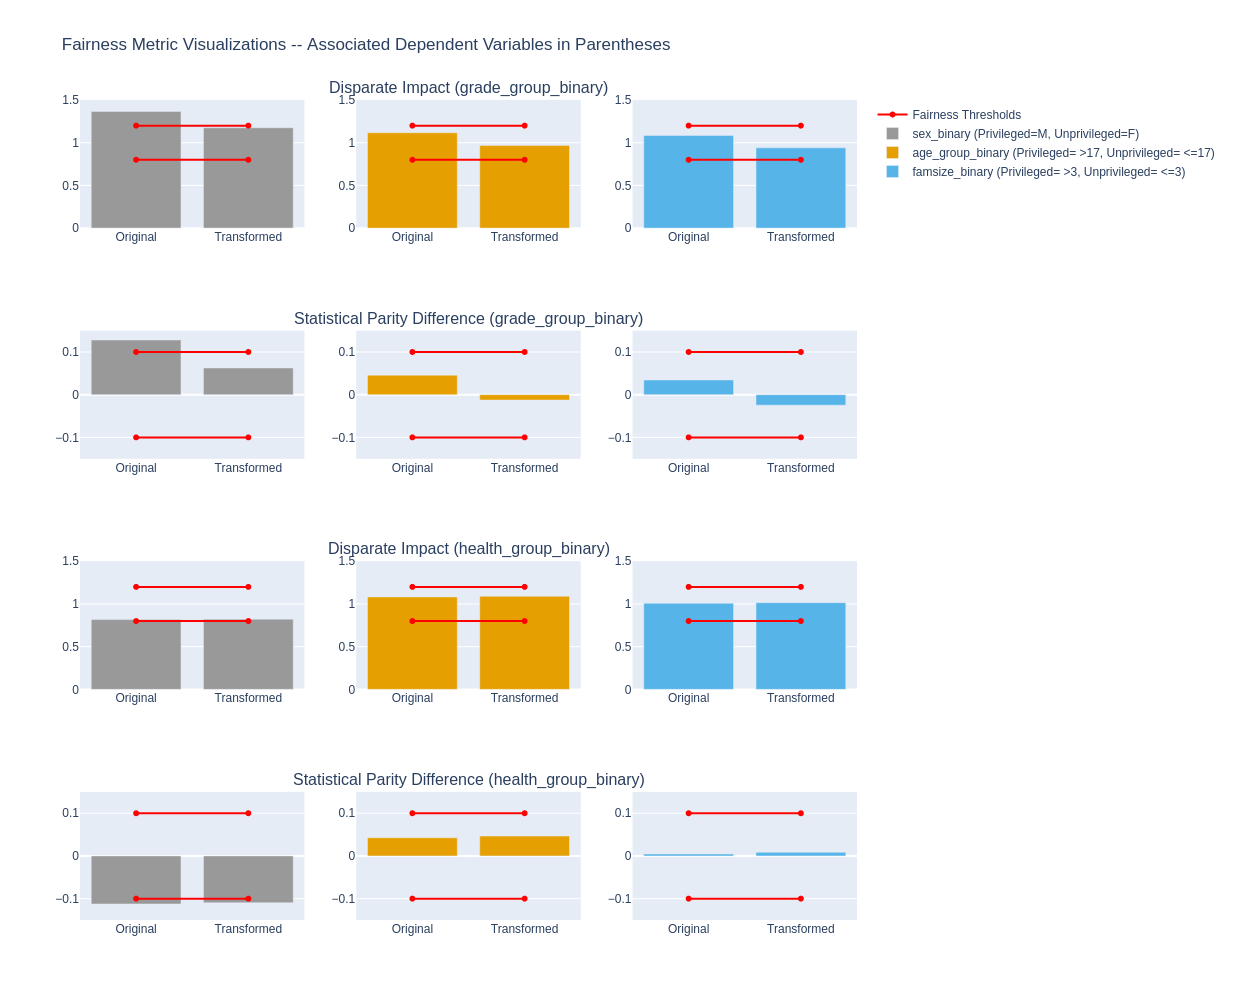

In [7]:
# colorblind palette:
palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig = make_subplots(
    rows=4, cols=3,
    subplot_titles=[
        None,
        'Disparate Impact (grade_group_binary)',
        None,
        None,
        'Statistical Parity Difference (grade_group_binary)',
        None,
        None,
        'Disparate Impact (health_group_binary)',
        None,
        None,
        'Statistical Parity Difference (health_group_binary)',
        None
    ]
)
    
fig.update_layout(
    height=1_000, 
    width=800,
    title_text='Fairness Metric Visualizations -- Associated Dependent Variables in Parentheses'
)

#### Row 1
fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[1.2, 1.2],
        marker=dict(color='red'),
        name='Fairness Thresholds'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[1.366630, 1.175284],
        name='sex_binary (Privileged=M, Unprivileged=F)',
        marker={'color': palette[0]},
        showlegend=True
    ),
    row=1, col=1
)



fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.8, 0.8],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=1, col=1
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[1.116679, 0.968666],
        name='age_group_binary (Privileged= >17, Unprivileged= <=17)',
        marker={'color': palette[1]},
        showlegend=True
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[1.2, 1.2],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.8, 0.8],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=1, col=2
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[1.085794, 0.940309],
        name='famsize_binary (Privileged= >3, Unprivileged= <=3)',
        marker={'color': palette[2]},
        showlegend=True
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[1.2, 1.2],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.8, 0.8],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=1, col=3
)


#### Row 2
fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.1, 0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=2, col=1
)

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[0.128183, 0.062540],
        name='sex_binary (Privileged=M, Unprivileged=F)',
        marker={'color': palette[0]},
        showlegend=False
    ),
    row=2, col=1
)



fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[-0.1, -0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=2, col=1
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[0.04577, -0.0126],
        name='age_group_binary (Privileged= >17, Unprivileged= <=17)',
        marker={'color': palette[1]},
        showlegend=False
    ),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.1, 0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[-0.1, -0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=2, col=2
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[0.0344, -0.0245],
        name='famsize_binary (Privileged= >3, Unprivileged= <=3)',
        marker={'color': palette[2]},
        showlegend=False
    ),
    row=2, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.1, 0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=2, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[-0.1, -0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=2, col=3
)

#### Row 3
fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[1.2, 1.2],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=3, col=1
)

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[0.817, 0.822],
        name='sex_binary (Privileged=M, Unprivileged=F)',
        marker={'color': palette[0]},
        showlegend=False
    ),
    row=3, col=1
)



fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.8, 0.8],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=3, col=1
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[1.082, 1.09],
        name='age_group_binary (Privileged= >17, Unprivileged= <=17)',
        marker={'color': palette[1]},
        showlegend=False
    ),
    row=3, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[1.2, 1.2],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=3, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.8, 0.8],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=3, col=2
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[1.008, 1.015],
        name='famsize_binary (Privileged= >3, Unprivileged= <=3)',
        marker={'color': palette[2]},
        showlegend=False
    ),
    row=3, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[1.2, 1.2],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=3, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.8, 0.8],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=3, col=3
)

#### Row 4
fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.1, 0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=4, col=1
)

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[-0.1126, -0.1096],
        name='sex_binary (Privileged=M, Unprivileged=F)',
        marker={'color': palette[0]},
        showlegend=False
    ),
    row=4, col=1
)



fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[-0.1, -0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=4, col=1
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[0.0426, 0.0466],
        name='age_group_binary (Privileged= >17, Unprivileged= <=17)',
        marker={'color': palette[1]},
        showlegend=False
    ),
    row=4, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.1, 0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=4, col=2
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[-0.1, -0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=4, col=2
)

####

fig.add_trace(
    go.Bar(
        x=['Original', 'Transformed'],
        y=[0.0045, 0.0084],
        name='famsize_binary (Privileged= >3, Unprivileged= <=3)',
        marker={'color': palette[2]},
        showlegend=False
    ),
    row=4, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[0.1, 0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=4, col=3
)

fig.add_trace(
    go.Scatter(
        x=['Original', 'Transformed'],
        y=[-0.1, -0.1],
        marker=dict(color='red'),
        name='Fairness Thresholds',
        showlegend=False
    ),
    row=4, col=3
)



fig.update_yaxes(range=[0, 1.5], row=1)
fig.update_yaxes(range=[-0.15, 0.15], row=2)
fig.update_yaxes(range=[0, 1.5], row=3)
fig.update_yaxes(range=[-0.15, 0.15], row=4)


fig.show()